# 9. Spatial Gillespie Method

## 9.1. Spaces in E-Cell4

What the space in E-Cell4 looks like?

In [1]:
from ecell4 import *

w1 = ode.ODEWorld(Real3(1, 1, 1))
w2 = gillespie.GillespieWorld(Real3(1, 1, 1))

We created a cube size, `1`, on a side for `ODEWorld` and `GillespieWorld`. In this case the volume only matters, that is

In [2]:
w3 = ode.ODEWorld(Real3(2, 0.5, 1))  # is almost equivalent to 'w1'
w4 = gillespie.GillespieWorld(Real3(2, 2, 0.25))  # is almost equivalent to 'w2'

This returns the same results. Because the volume is same as `1`.

This seems reasonable in homogeneous system, but the cell is NOT homogeneous. So we need to consider a space for molecular localization.

You can use several types of space and simulation methods in E-Cell4. We show an example with spatial Gillespie method here.

## 9.2. Spatial Gillespie Method

In E-Cell4, the Spatial Gillespie method is included in `meso` module. Let's start with `run_simulation` like `ode`.

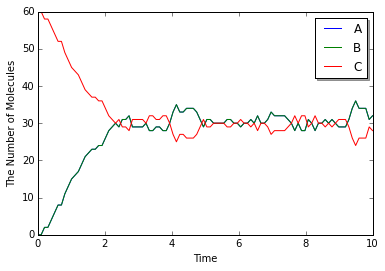

In [3]:
%matplotlib inline
import numpy
from ecell4 import *

with reaction_rules():
    A + B == C | (0.01, 0.3)

y = run_simulation(numpy.linspace(0, 10, 100), {'C': 60}, solver='meso')

At the steady state, the number of `C` is given as follows:

$$
\frac{d\mathrm{C}}{dt}=0.01{\cdot}\frac{\mathrm{A}}{V}{\cdot}\frac{\mathrm{B}}{V}-0.3{\cdot}\frac{\mathrm{C}}{V}=0\\
0.01\left(60-\mathrm{C}\right)^2=0.3\mathrm{C}\times V\\
\mathrm{C}=30.
$$

You will obtain almost the same result with `ode` or `gillespie` (may take longer time than `ode` or `gillespie`).
This is not surprising because `meso` module is almost same with Gillespie unless you give additional spatial parameter.

Next we will decompose `run_simulation`.

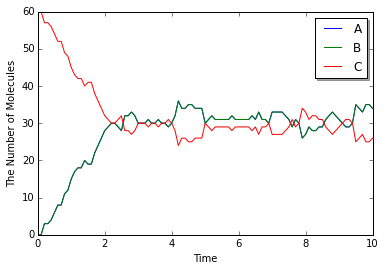

In [4]:
from ecell4 import *

with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

w = meso.MesoscopicWorld(Real3(1, 1, 1), Integer3(1, 1, 1))  # XXX: Point2
w.bind_to(m)  # XXX: Point1
w.add_molecules(Species('C'), 60)

sim = meso.MesoscopicSimulator(w)  # XXX: Point1
obs = FixedIntervalNumberObserver(0.1, ('A', 'B', 'C'))
sim.run(10, obs)

viz.plot_number_observer(obs)

This is nothing out of the ordinary one except for `MesoscopicWorld` and `MesoscopicSimulator`, but you can see some new elements.

First in `w.bind_to(m)` we asscociated a `Model` to the `World`.
In the basic exercises before, we did NOT do this.
In spatial methods, `Species` attributes are necessary. Do not forget to call this.
After that, only the `World` is required to create a `MesoscopicSimulator`.

Next, the important difference is the second argument for MesoscopicWorld, i.e. `Integer3(1, 1, 1)`.
`ODEWorld` and `GillespieWorld` do NOT have this second argument.
Before we explain this, let's change this argument and run the simulation again.

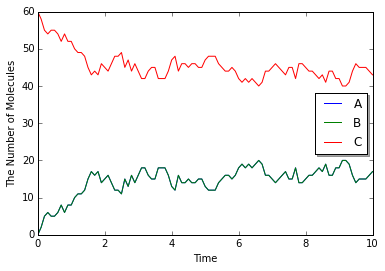

In [5]:
from ecell4 import *

with reaction_rules():
    A + B == C | (0.01, 0.3)

m = get_model()

w = meso.MesoscopicWorld(Real3(1, 1, 1), Integer3(4, 4, 4))  # XXX: Point2
w.bind_to(m)  # XXX: Point1
w.add_molecules(Species('C'), 60)

sim = meso.MesoscopicSimulator(w)  # XXX: Point1
obs = FixedIntervalNumberObserver(0.1, ('A', 'B', 'C'))
sim.run(10, obs)

viz.plot_number_observer(obs)

You must have the different plot. If you increase value in the `Integer3`, you will have more different one.  
Actually this second argument means the number of spatical partitions. `meso` is almost same with `gillespie`, but `meso` divides the space into cuboids (we call these cuboids subvolumes) and each subvolume has different molecular concentration by contrast `gillespie` has only one uniform closed space. So in the preceding example, we divided `1` cube with sides `1` into `64` (4x4x4) cubes with sides `0.25`. We threw 60 `C` molecules into the `World`. Thus, each `subvolume` has 1 species at most.

## 9.3. Defining Molecular Diffusion Coefficient

Where the difference is coming from? This is because we do NOT consider molecular diffusion coefficient, although we got a space with `meso`. To setup diffusion coefficient, use `Species` attribute `'D'` in the way described before ([2. How to Build a Model](2. How to Build a Model.ipynb)).
As shown in [1. Brief Tour of E-Cell4 Simulations](1. Brief Tour of E-Cell4 Simulations.ipynb), we use E-Cell4 special notation here.

In [6]:
with species_attributes():
    A | {'D': '1'}
    B | {'D': '1'}
    C | {'D': '1'}

    # A | B | C | {'D': '1'}  # means the same as above

get_model()

You can setup diffusion coefficient with `with species_attributes():` statement. Here we set all the diffusion coefficient as `1`. Let's simulate this model again. Now you must have the almost same result with `gillespie` even with large `Integer3` value (the simulation will takes much longer than `gillespie`).

How did the molecular diffusion work for the problem? Think about free diffusion (the diffusion coefficient of a Species is $D$) in 3D space. The unit of diffusion coefficient is the square of length divided by time like 
$\mathrm{\mu m}^2/s$ or $\mathrm{nm}^2/\mu s$.

It is known that the average of the square of point distance from time $0$ to $t$ is equal to $6Dt$.
Conversely the average of the time scale in a space with length scale $l$ is about $l^2/6D$.  

In the above case, the size of each subvolume is 0.25 and the diffusion coefficient is 1. Thus the time scale is about 0.01 sec.
If the molecules of the `Species` `A` and `B` are in the same subvolume, it takes about 1.5 sec to react, so in most cases the diffusion is faster than the reaction and the molecules move to other subvolume even dissociated in the same subvolume.
The smaller $l$, the smaller subvolume's volume $l^3$, so the reaction rate after dissociation is faster, and the time of the diffusion and the transition between the subvolume gets smaller too.

## 9.4. Molecular localization

We have used `add_molecules` function to add molecules to `World` in the same manner as `ode` or `gillespie`.
Meanwhile in `MesoscopicWorld`, you can put in molecules according to the spatial presentation.

In [7]:
from ecell4 import *

w = meso.MesoscopicWorld(Real3(1, 1, 1), Integer3(3, 3, 3))
w.add_molecules(Species('A'), 120)
w.add_molecules(Species('B'), 120, Integer3(1, 1, 1))

In `MesoscopicWorld`, you can set the subvolume and the molecule locations by giving the third argument `Integer3` to `add_molecules`.
In the above example, the molecule type `A` spreads all over the space, but the molecule type `B` only locates in a subvolume at the center of the volume.
To check this, use `num_molecules` function with a coordinate.

In [8]:
print(w.num_molecules(Species('B')))  # must print 120
print(w.num_molecules(Species('B'), Integer3(0, 0, 0)))  # must print 0
print(w.num_molecules(Species('B'), Integer3(1, 1, 1)))  # must print 120

120
0
120


Furthermore, if you have IPython Notebook environment, you can visualize the molecular localization with `ecell4.viz` module.

In [9]:
viz.plot_world(w, radius=0.01)

`viz.plot_world` function visualize the location of the molecules in IPython Notebook cell by giving the `World`. You can set the molecule size with `radius`.
Now you can set the molecular localization to the `World`, next let's simulate this.
In the above example, we set the diffusion coefficient 1 and the World side 1, so 10 seconds is enough to stir this.
After the simulation, check the result with calling `viz.plot_world` again.

## 9.5. Molecular initial location and the reaction

This is an extreme example to check how the molecular localization affects the reaction.

In [10]:
%matplotlib inline
from ecell4 import *

with species_attributes():
    A | B | C | {'D': '1'}

with reaction_rules():
    A + B > C | 0.01

m = get_model()
w = meso.MesoscopicWorld(Real3(10, 1, 1), Integer3(10, 1, 1))
w.bind_to(m)

This model consists only of a simple binding reaction. The `World` is a long x axis cuboid, and molecules are located off-center.

In [11]:
w.add_molecules(Species('A'), 1200, Integer3(2, 0, 0))
w.add_molecules(Species('B'), 1200, Integer3(7, 0, 0))
viz.plot_world(w, radius=0.025)

On a different note, there is a reason not to set `Integer3(0, 0, 0)` or `Integer3(9, 0, 0)`.
In E-Cell4, basically we adopt periodic boundary condition for everything.
So the forementioned two subvolumes are actually adjoining.

After realizing the location expected, simulate it with `MesoscopicSimulator`.

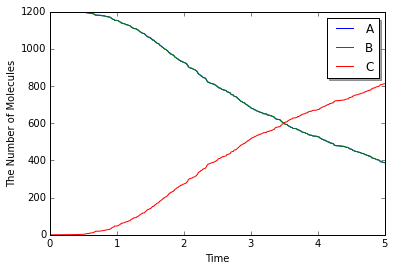

In [12]:
sim = meso.MesoscopicSimulator(w)
obs1 = NumberObserver(('A', 'B', 'C'))  # XXX: saves the numbers after every steps
sim.run(5, obs1)
viz.plot_number_observer(obs1)

In [13]:
viz.plot_world(w, radius=0.025)

To check the effect of initial coordinates, we recommend that you locate the molecules homogeneously with `meso` or simulate with `gillespie`.

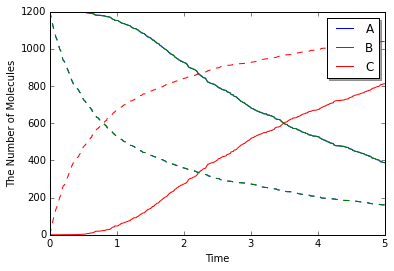

In [14]:
w = meso.MesoscopicWorld(Real3(10, 1, 1), Integer3(10, 1, 1))
w.bind_to(m)
w.add_molecules(Species('A'), 1200)
w.add_molecules(Species('B'), 1200)

sim = meso.MesoscopicSimulator(w)
obs2 = NumberObserver(('A', 'B', 'C'))  # XXX: saves the numbers after every steps
sim.run(5, obs2)
viz.plot_number_observer(obs1, "-", obs2, "--")

The solid line is biased case, and the dash line is non-biased.
The biased reaction is obviously slow.
And you may notice that the shape of time-series is also different between the solid and dash lines.
This is because it takes some time for the molecule `A` and `B` to collide due to the initial separation.
Actually it takes $4^2/2(D_\mathrm{A}+D_\mathrm{B})=4$ seconds to move the initial distance between `A` and `B` (about 4).